# Data Center Energy Analysis - Zip 93309

This notebook analyzes energy usage patterns for ZIP code 93309, utilizing other 933xx ZIP codes as a baseline for comparison. The goal is to identify major usage spikes potentially indicative of data center loads. It includes a specific check for "Load Masking" where high demand might be shifted to neighboring ZIP codes.

In [8]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')

# Load the cleaned dataset
data_path = 'pge_electric_usage_2015_2025_cleaned.csv'
combined_df = pd.read_csv(data_path)

print(f"✓ Data loaded: {combined_df.shape}")

✓ Data loaded: (286862, 12)


## Filter Data
Filtering for Commercial, Residential, and Industrial customers.

In [9]:
valid_customer_classes = ['Elec- Commercial', 'Elec- Residential', 'Elec- Industrial']
combined_df = combined_df[combined_df['CUSTOMERCLASS'].isin(valid_customer_classes)].copy()

print(f"✓ Filtered to relevant classes: {len(combined_df):,} rows")

✓ Filtered to relevant classes: 217,953 rows


## Analysis Setup for 93309

In [10]:
# Define ZIP codes
data_center_zip = 93309
comparison_zips = [93301, 93304, 93305, 93306, 93307, 93308, 93311, 93312, 93313, 93314]
all_target_zips = [data_center_zip] + comparison_zips

print("Analysis Setup:")
print(f"  Target ZIP: {data_center_zip}")
print(f"  Comparison ZIPs: {comparison_zips}")

# Filter for target ZIPs
target_data = combined_df[combined_df['ZIPCODE'].isin(all_target_zips)].copy()

# Create year-month column
target_data['YEAR_MONTH'] = pd.to_datetime(
    target_data['YEAR'].astype(str) + '-' + target_data['MONTH'].astype(str).str.zfill(2) + '-01'
)

print(f"\n✓ Filtered to target ZIPs: {len(target_data):,} rows")

Analysis Setup:
  Target ZIP: 93309
  Comparison ZIPs: [93301, 93304, 93305, 93306, 93307, 93308, 93311, 93312, 93313, 93314]

✓ Filtered to target ZIPs: 3,314 rows


## Load Masking Detection & Correction
Checking for instances where usage might be masked by shifting it to neighboring ZIPs.

In [11]:
def detect_and_correct_load_masking(data, data_center_zip, neighbor_zips):
    """
    Detects load masking in data center ZIP and reallocates usage from neighbors.
    """
    corrected_data = data.copy()
    reallocation_log = []
    
    # Calculate baseline (median) for each ZIP
    baselines = data.groupby('ZIPCODE')['TOTALKWH'].median().to_dict()
    dc_baseline = baselines.get(data_center_zip, 0)
    
    # Define suspicious threshold (50% below baseline)
    suspicious_threshold = dc_baseline * 0.5
    
    # Get data center monthly records
    dc_records = corrected_data[corrected_data['ZIPCODE'] == data_center_zip].copy()
    
    print(f"Load Masking Detection for ZIP {data_center_zip}")
    print("=" * 80)
    print(f"Baseline (median) usage: {dc_baseline:,.0f} kWh")
    print(f"Suspicious threshold (50% of baseline): {suspicious_threshold:,.0f} kWh")
    
    suspicious_count = 0
    reallocated_count = 0
    
    for idx, row in dc_records.iterrows():
        if row['TOTALKWH'] < suspicious_threshold:
            suspicious_count += 1
            year_month = row['YEAR_MONTH']
            original_usage = row['TOTALKWH']
            
            # Check neighboring ZIPs for excess usage during this period
            neighbor_data = corrected_data[
                (corrected_data['ZIPCODE'].isin(neighbor_zips)) &
                (corrected_data['YEAR_MONTH'] == year_month)
            ]
            
            # Find ZIP with highest excess above its baseline
            best_candidate = None
            max_excess_pct = 0
            
            for _, neighbor_row in neighbor_data.iterrows():
                neighbor_zip = neighbor_row['ZIPCODE']
                neighbor_usage = neighbor_row['TOTALKWH']
                neighbor_baseline = baselines.get(neighbor_zip, neighbor_usage)
                
                if neighbor_baseline > 0:
                    excess = neighbor_usage - neighbor_baseline
                    excess_pct = (excess / neighbor_baseline) * 100
                    
                    # Consider candidates with 50%+ excess above baseline
                    if excess_pct > 50 and excess_pct > max_excess_pct:
                        max_excess_pct = excess_pct
                        best_candidate = {
                            'zip': neighbor_zip,
                            'usage': neighbor_usage,
                            'baseline': neighbor_baseline,
                            'excess': excess,
                            'excess_pct': excess_pct,
                            'idx': neighbor_row.name
                        }
            
            # If strong candidate found, reallocate the excess
            if best_candidate and best_candidate['excess'] > 0:
                reallocated_count += 1
                
                # Amount to reallocate (the excess usage)
                reallocation_amount = best_candidate['excess']
                
                # Update data center usage
                corrected_data.loc[idx, 'TOTALKWH'] = original_usage + reallocation_amount
                
                # Reduce neighbor's reported usage
                neighbor_idx = best_candidate['idx']
                corrected_data.loc[neighbor_idx, 'TOTALKWH'] = best_candidate['usage'] - reallocation_amount
                
                # Log the reallocation
                reallocation_log.append({
                    'date': year_month,
                    'dc_original': original_usage,
                    'dc_corrected': original_usage + reallocation_amount,
                    'source_zip': best_candidate['zip'],
                    'source_original': best_candidate['usage'],
                    'source_corrected': best_candidate['usage'] - reallocation_amount,
                    'reallocated_kwh': reallocation_amount,
                    'excess_pct': best_candidate['excess_pct']
                })
    
    print(f"\nSuspicious low-usage periods detected: {suspicious_count}")
    print(f"Reallocations performed: {reallocated_count}")
    
    if reallocated_count > 0:
        print(f"\nSample Reallocations (first 5):")
        print("-" * 80)
        for i, log in enumerate(reallocation_log[:5]):
            date_str = log['date'].strftime('%b %Y')
            print(f"{date_str}: Reallocated {log['reallocated_kwh']:,.0f} kWh from ZIP {log['source_zip']}")
            print(f"  Target: {log['dc_original']:,.0f} → {log['dc_corrected']:,.0f} kWh")
            print(f"  Source ({log['source_zip']}): {log['source_original']:,.0f} → {log['source_corrected']:,.0f} kWh")

    return corrected_data, reallocation_log

# Pre-aggregate monthly data for all ZIPs
monthly_detection = target_data.groupby(['ZIPCODE', 'YEAR_MONTH']).agg({
    'TOTALKWH': 'sum',
    'TOTALCUSTOMERS': 'sum'
}).reset_index()

# Apply load masking correction
corrected_monthly, reallocation_log = detect_and_correct_load_masking(
    monthly_detection, 
    data_center_zip, 
    comparison_zips # Using local 933xx neighbors as candidates
)

Load Masking Detection for ZIP 93309
Baseline (median) usage: 19,639,400 kWh
Suspicious threshold (50% of baseline): 9,819,700 kWh

Suspicious low-usage periods detected: 24
Reallocations performed: 10

Sample Reallocations (first 5):
--------------------------------------------------------------------------------
Nov 2016: Reallocated 19,348,337 kWh from ZIP 93313
  Target: 9,549,297 → 28,897,634 kWh
  Source (93313): 33,275,335 → 13,926,998 kWh
Mar 2017: Reallocated 15,408,060 kWh from ZIP 93313
  Target: 8,625,912 → 24,033,972 kWh
  Source (93313): 29,335,058 → 13,926,998 kWh
Nov 2023: Reallocated 66,344,326 kWh from ZIP 93307
  Target: 9,075,039 → 75,419,365 kWh
  Source (93307): 98,110,027 → 31,765,701 kWh
Feb 2024: Reallocated 53,193,802 kWh from ZIP 93307
  Target: 8,506,665 → 61,700,467 kWh
  Source (93307): 84,959,503 → 31,765,701 kWh
Mar 2024: Reallocated 56,506,299 kWh from ZIP 93307
  Target: 8,390,777 → 64,897,076 kWh
  Source (93307): 88,272,000 → 31,765,701 kWh


## Aggregate Monthly Usage (Corrected)

In [12]:
# Split into target and comparison using CORRECTED data
dc_usage = corrected_monthly[corrected_monthly['ZIPCODE'] == data_center_zip].copy()
comp_usage = corrected_monthly[corrected_monthly['ZIPCODE'].isin(comparison_zips)].copy()

# Calculate average of comparison ZIPs
comp_avg = comp_usage.groupby('YEAR_MONTH').agg({
    'TOTALKWH': 'mean',
    'TOTALCUSTOMERS': 'mean'
}).reset_index()

dc_usage_sorted = dc_usage.sort_values('YEAR_MONTH').copy()

print(f"✓ Monthly aggregation complete (using corrected data)")
print(f"  Target Zip Months: {len(dc_usage)}")
print(f"  Comparison Months: {len(comp_avg)}")

✓ Monthly aggregation complete (using corrected data)
  Target Zip Months: 111
  Comparison Months: 111


## Calculate Statistics

In [13]:
# Month-over-month changes
dc_usage_sorted['PREV_KWH'] = dc_usage_sorted['TOTALKWH'].shift(1)
dc_usage_sorted['MOM_CHANGE'] = dc_usage_sorted['TOTALKWH'] - dc_usage_sorted['PREV_KWH']
dc_usage_sorted['MOM_PCT_CHANGE'] = (dc_usage_sorted['MOM_CHANGE'] / dc_usage_sorted['PREV_KWH'] * 100)

# Statistics
dc_mean = dc_usage_sorted['TOTALKWH'].mean()
comp_mean = comp_avg['TOTALKWH'].mean()
difference = dc_mean - comp_mean
pct_difference = (difference / comp_mean) * 100

print("Overall Statistics:")
print(f"  Target Zip Average: {dc_mean:,.0f} kWh")
print(f"  Comparison Average: {comp_mean:,.0f} kWh")
print(f"  Difference: {difference:+,.0f} kWh ({pct_difference:+.1f}%)")
print(f"\n  Target Peak: {dc_usage_sorted['TOTALKWH'].max():,.0f} kWh")
print(f"  Comparison Peak: {comp_avg['TOTALKWH'].max():,.0f} kWh")

Overall Statistics:
  Target Zip Average: 26,127,826 kWh
  Comparison Average: 33,794,564 kWh
  Difference: -7,666,738 kWh (-22.7%)

  Target Peak: 76,493,844 kWh
  Comparison Peak: 82,112,496 kWh


## Identify Major Usage Spikes

In [14]:
print("Top 10 Peak Usage Months for 93309:")
print("=" * 70)
top_months = dc_usage_sorted.nlargest(10, 'TOTALKWH')[['YEAR_MONTH', 'TOTALKWH']]
for idx, row in top_months.iterrows():
    date_str = row['YEAR_MONTH'].strftime('%B %Y')
    print(f"{date_str:20} | {row['TOTALKWH']:>12,.0f} kWh")

print("\n\nTop 10 Largest Month-over-Month Increases:")
print("=" * 70)
top_increases = dc_usage_sorted.nlargest(10, 'MOM_CHANGE')[['YEAR_MONTH', 'TOTALKWH', 'MOM_CHANGE', 'MOM_PCT_CHANGE']]
for idx, row in top_increases.iterrows():
    date_str = row['YEAR_MONTH'].strftime('%B %Y')
    print(f"{date_str:20} | Usage: {row['TOTALKWH']:>12,.0f} kWh | Change: +{row['MOM_CHANGE']:>12,.0f} kWh ({row['MOM_PCT_CHANGE']:>6.1f}%)")

Top 10 Peak Usage Months for 93309:
April 2025           |   76,493,844 kWh
November 2023        |   75,419,365 kWh
March 2025           |   73,704,953 kWh
April 2024           |   69,271,128 kWh
September 2017       |   68,499,823 kWh
November 2024        |   67,076,350 kWh
March 2024           |   64,897,076 kWh
February 2024        |   61,700,467 kWh
February 2025        |   59,729,686 kWh
July 2020            |   50,864,821 kWh


Top 10 Largest Month-over-Month Increases:
November 2023        | Usage:   75,419,365 kWh | Change: +  63,362,604 kWh ( 525.5%)
November 2024        | Usage:   67,076,350 kWh | Change: +  52,998,860 kWh ( 376.5%)
February 2024        | Usage:   61,700,467 kWh | Change: +  51,391,708 kWh ( 498.5%)
February 2025        | Usage:   59,729,686 kWh | Change: +  49,519,745 kWh ( 485.0%)
June 2018            | Usage:   35,024,333 kWh | Change: +  23,047,651 kWh ( 192.4%)
September 2017       | Usage:   68,499,823 kWh | Change: +  20,917,674 kWh (  44.0%)
May 2017 

## Visualizing the Data
A comparison chart of the target zip vs average of others.

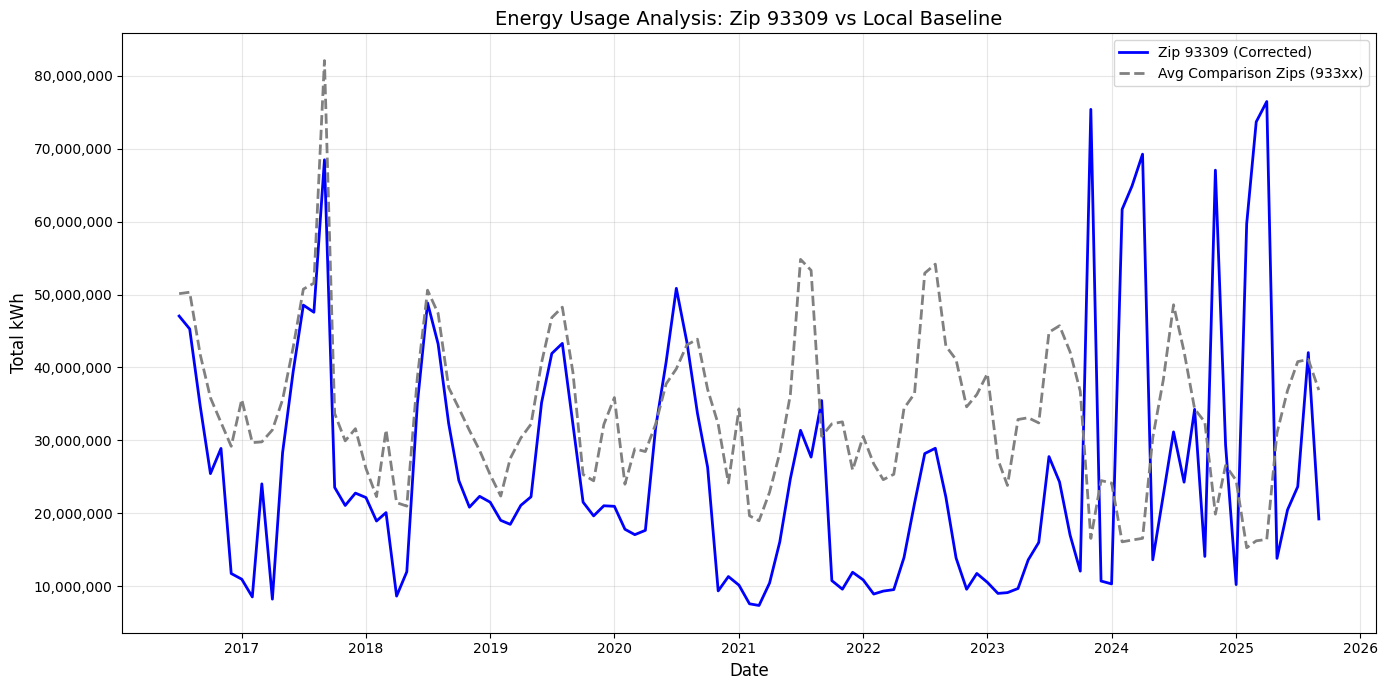

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(dc_usage_sorted['YEAR_MONTH'], dc_usage_sorted['TOTALKWH'], label='Zip 93309 (Corrected)', linewidth=2, color='blue')
plt.plot(comp_avg['YEAR_MONTH'], comp_avg['TOTALKWH'], label='Avg Comparison Zips (933xx)', linewidth=2, color='gray', linestyle='--')

plt.title('Energy Usage Analysis: Zip 93309 vs Local Baseline', fontsize=14)
plt.ylabel('Total kWh', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()